# Clients Churn Prediction

Telecom operator wants to predict a possible leak of it's clients. Company will offer some special benefits to those of them who's going to leave. Operator's team has collected personal data about their clients. So we need to build model that is able to predict their loss. 

## Exploratory data analysis

In [ ]:
# install libraries
!pip install catboost

     |████████████████████████████████| 76.1 MB 37 kB/s 


In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


In [ ]:
# load data and libraries
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn import metrics, model_selection
from catboost import CatBoostClassifier, Pool, CatBoost
import shap
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Telecom/final_provider/'
random_state=12345

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir(PATH)

In [ ]:
filenames = [i for i in glob.glob("*.csv")]
filenames

['phone.csv', 'personal.csv', 'internet.csv', 'contract.csv']

In [ ]:
data = pd.DataFrame(columns=['customerID'])
for file in filenames:
    frame = pd.read_csv(file)
    data = data.merge(frame, how='outer', on='customerID')

In [ ]:
data.head()

,customerID,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5575-GNVDE,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
1,3668-QPYBK,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
2,9237-HQITU,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
3,9305-CDSKC,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
4,1452-KIOVK,Yes,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4


In [ ]:
#check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   MultipleLines     6361 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
data.describe()

,SeniorCitizen,MonthlyCharges
count,7043.000000,7043.000000
mean,0.162147,64.761692
std,0.368612,30.090047
min,0.000000,18.250000
25%,0.000000,35.500000
50%,0.000000,70.350000
75%,0.000000,89.850000
max,1.000000,118.750000


In [ ]:
# get dataset headers lower

data.columns = map(str.lower, data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   multiplelines     6361 non-null   object 
 2   gender            7043 non-null   object 
 3   seniorcitizen     7043 non-null   int64  
 4   partner           7043 non-null   object 
 5   dependents        7043 non-null   object 
 6   internetservice   5517 non-null   object 
 7   onlinesecurity    5517 non-null   object 
 8   onlinebackup      5517 non-null   object 
 9   deviceprotection  5517 non-null   object 
 10  techsupport       5517 non-null   object 
 11  streamingtv       5517 non-null   object 
 12  streamingmovies   5517 non-null   object 
 13  begindate         7043 non-null   object 
 14  enddate           7043 non-null   object 
 15  type              7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


## Conclusion

 Data needs to
 - Do some preprocessing
 - Extract target
 - Find outstanding values and artefacts
 - Handle missing values

## Data Preprocessing

In [ ]:
#get target
def get_target(dataset):
  if dataset == 'No':
    target = 0
  else:
    target = 1
  return target 

data['has_left'] = data['enddate'].apply(get_target)
data.head()   

,customerid,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_left
0,5575-GNVDE,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
1,3668-QPYBK,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
2,9237-HQITU,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
3,9305-CDSKC,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,1
4,1452-KIOVK,Yes,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0


In [ ]:
data['enddate_today'] = data['enddate'].apply(lambda x: '2020-02-01' if x=='No' else x)
data.head()

,customerid,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_left,enddate_today
0,5575-GNVDE,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,2020-02-01
1,3668-QPYBK,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,2019-12-01 00:00:00
2,9237-HQITU,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,2019-11-01 00:00:00
3,9305-CDSKC,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,1,2019-11-01 00:00:00
4,1452-KIOVK,Yes,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0,2020-02-01


In [ ]:
#switch data type to an apropriate one
data['begindate'] = pd.to_datetime(data['begindate'])
data['enddate_today'] = pd.to_datetime(data['enddate_today'])
data['enddate'] = pd.to_datetime(data['enddate'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   multiplelines     6361 non-null   object        
 2   gender            7043 non-null   object        
 3   seniorcitizen     7043 non-null   int64         
 4   partner           7043 non-null   object        
 5   dependents        7043 non-null   object        
 6   internetservice   5517 non-null   object        
 7   onlinesecurity    5517 non-null   object        
 8   onlinebackup      5517 non-null   object        
 9   deviceprotection  5517 non-null   object        
 10  techsupport       5517 non-null   object        
 11  streamingtv       5517 non-null   object        
 12  streamingmovies   5517 non-null   object        
 13  begindate         7043 non-null   datetime64[ns]
 14  enddate           1869 n

In [ ]:
#calculate client's lifetime
data['lifetime'] = (data['enddate_today'] - data['begindate']) / np.timedelta64(1, 'D')


In [ ]:
data.head()

,customerid,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_left,enddate_today,lifetime
0,5575-GNVDE,No,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,0,2020-02-01,1036.0
1,3668-QPYBK,No,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2019-12-01,61.0
2,9237-HQITU,No,Female,0,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2019-11-01,61.0
3,9305-CDSKC,Yes,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5,1,2019-11-01,245.0
4,1452-KIOVK,Yes,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0,2020-02-01,671.0


Text(0.5, 1.0, 'quit date distribution')

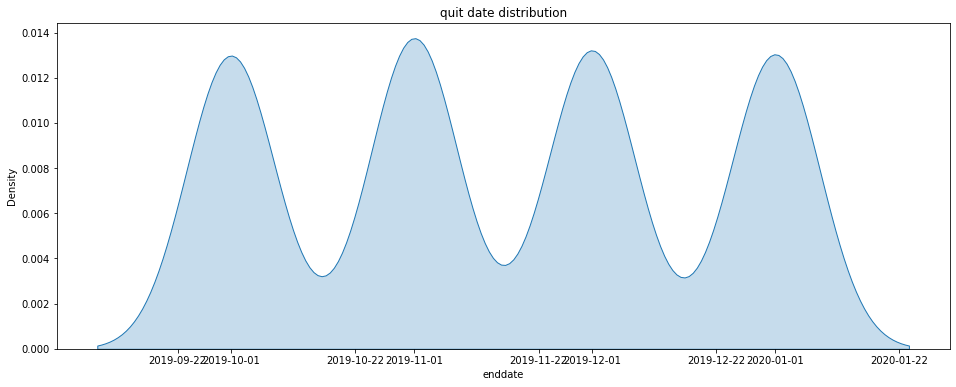

In [ ]:
# quit date distribution
plt.figure(figsize=(16,6))
sns.kdeplot(data=data['enddate'], label="date", shade=True)
plt.title('quit date distribution')

Clients churn is almost the same in each month

Text(0.5, 1.0, 'clients lfetime distribution')

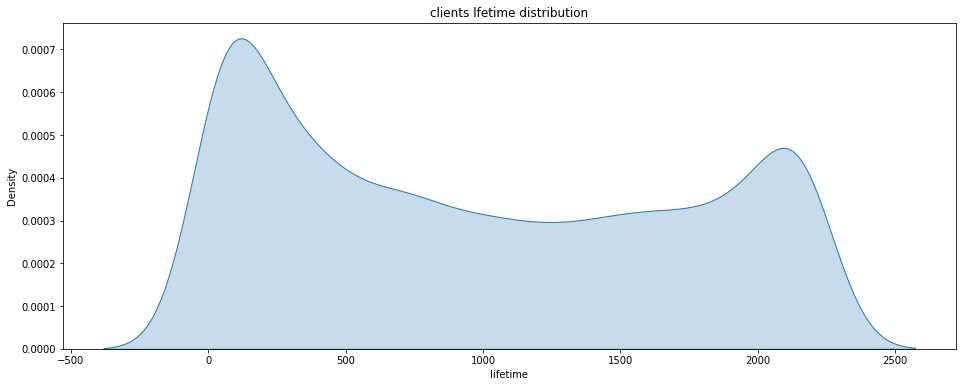

In [ ]:
# quit date distribution
plt.figure(figsize=(16,6))
sns.kdeplot(data=data['lifetime'], label="days", shade=True)
plt.title('client''s lfetime distribution')

After 200 days probability of loosing client increases significantly

In [ ]:
#drop date columns
data = data.drop(['begindate', 'enddate', 'enddate_today'], axis=1)

In [ ]:
# miising values
data['multiplelines'].isna().value_counts(normalize=True)

False    0.903166
True     0.096834
Name: multiplelines, dtype: float64

In [ ]:
data['multiplelines'].value_counts()

No     3390
Yes    2971
Name: multiplelines, dtype: int64

In [ ]:
data['multiplelines'] = data['multiplelines'].fillna('No')

In [ ]:
# data['totalcharges'] = data['totalcharges'].astype('float')
# run of this cell raises an error: ValueError: could not convert string to float: 
# probably couse of the bad rows

In [ ]:
# find the bad rows in data['totalcharges'] column
bad_rows = []
for i in range(len(data)):
  try:
    data['totalcharges'].values[i] = float(data['totalcharges'].values[i])
  except:
    bad_rows.append(i)
    print(i)

682
847
982
3024
3482
3976
4731
6033
6106
6413
6484


In [ ]:
list(np.array(bad_rows))

[682, 847, 982, 3024, 3482, 3976, 4731, 6033, 6106, 6413, 6484]

In [ ]:
# let's look what the problem is
data['totalcharges'].iloc[3024]

' '

In [ ]:
data.iloc[list(np.array(bad_rows))]

,customerid,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_left,lifetime
682,3115-CZMZD,No,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,20.25,,0,0.0
847,5709-LVOEQ,No,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0,0.0
982,4367-NUYAO,Yes,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,25.75,,0,0.0
3024,7644-OMVMY,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,19.85,,0,0.0
3482,3213-VVOLG,Yes,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,25.35,,0,0.0
3976,2520-SGTTA,No,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,20.00,,0,0.0
4731,2923-ARZLG,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One year,Yes,Mailed check,19.70,,0,0.0
6033,4075-WKNIU,Yes,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0,0.0
6106,2775-SEFEE,Yes,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0,0.0
6413,4472-LVYGI,No,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0,0.0


It turns out that the new clients has missing values in totalcharges columns. They made prepayment for further month (it revealed in the monthlycharges column), but total charges are not calculated yet


In [ ]:
#drop bad rows
data = data.drop(list(np.array(bad_rows)), axis=0)

In [ ]:
# #fill missing values in totalcharges column by values from monthlycharges
# data['totalcharges'].iloc[list(np.array(bad_rows))] = data['monthlycharges'].iloc[list(np.array(bad_rows))]

In [ ]:
#switch a datatype to float
data['totalcharges'] = data['totalcharges'].astype('float')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   multiplelines     7032 non-null   object 
 2   gender            7032 non-null   object 
 3   seniorcitizen     7032 non-null   int64  
 4   partner           7032 non-null   object 
 5   dependents        7032 non-null   object 
 6   internetservice   5512 non-null   object 
 7   onlinesecurity    5512 non-null   object 
 8   onlinebackup      5512 non-null   object 
 9   deviceprotection  5512 non-null   object 
 10  techsupport       5512 non-null   object 
 11  streamingtv       5512 non-null   object 
 12  streamingmovies   5512 non-null   object 
 13  type              7032 non-null   object 
 14  paperlessbilling  7032 non-null   object 
 15  paymentmethod     7032 non-null   object 
 16  monthlycharges    7032 non-null   float64


In [ ]:
data[data['internetservice'].isna()]

,customerid,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,has_left,lifetime
8,7469-LKBCI,No,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Credit card (automatic),18.95,326.80,0,488.0
13,8191-XWSZG,No,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One year,No,Mailed check,20.65,1022.95,0,1584.0
17,1680-VDCWW,No,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One year,No,Bank transfer (automatic),19.80,202.25,0,365.0
18,1066-JKSGK,No,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,No,Mailed check,20.15,20.15,1,30.0
28,7310-EGVHZ,No,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,No,Bank transfer (automatic),20.20,20.20,0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,4807-IZYOZ,No,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Bank transfer (automatic),20.65,1020.75,0,1553.0
6340,9710-NJERN,No,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two year,No,Mailed check,20.15,826.00,0,1187.0
6341,9837-FWLCH,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,Yes,Electronic check,19.20,239.00,0,365.0
6350,0871-OPBXW,No,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,Yes,Mailed check,20.05,39.25,0,62.0


In [ ]:
data = data.fillna('No')

In [ ]:
data = data.drop('customerid', axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   multiplelines     7032 non-null   object 
 1   gender            7032 non-null   object 
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   object 
 4   dependents        7032 non-null   object 
 5   internetservice   7032 non-null   object 
 6   onlinesecurity    7032 non-null   object 
 7   onlinebackup      7032 non-null   object 
 8   deviceprotection  7032 non-null   object 
 9   techsupport       7032 non-null   object 
 10  streamingtv       7032 non-null   object 
 11  streamingmovies   7032 non-null   object 
 12  type              7032 non-null   object 
 13  paperlessbilling  7032 non-null   object 
 14  paymentmethod     7032 non-null   object 
 15  monthlycharges    7032 non-null   float64
 16  totalcharges      7032 non-null   float64


In [ ]:
#check target disbalance
data['has_left'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: has_left, dtype: float64

In [ ]:
#look at the data correlations
data.corr()

,seniorcitizen,monthlycharges,totalcharges,has_left,lifetime
seniorcitizen,1.000000,0.219874,0.102411,0.150541,0.015630
monthlycharges,0.219874,1.000000,0.651065,0.192858,0.246715
totalcharges,0.102411,0.651065,1.000000,-0.199484,0.825811
has_left,0.150541,0.192858,-0.199484,1.000000,-0.354496
lifetime,0.015630,0.246715,0.825811,-0.354496,1.000000


## Conclusion

We've done some preprocessing work, extracted a new feature that has strong correlations with the target 


## Machine Learning

In [ ]:
#brake off features and targets from dataset
X = data.drop('has_left', axis =1)
y = pd.DataFrame(data['has_left'])

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=random_state, stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=random_state, stratify=y_test)

In [ ]:
#select categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
categorical_cols

['multiplelines',
 'gender',
 'partner',
 'dependents',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'type',
 'paperlessbilling',
 'paymentmethod']

In [ ]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((4219, 18), (1407, 18), (1406, 18), (1406, 1), (1407, 18), (1407, 1))

In [ ]:
#define a model
model = CatBoostClassifier(learning_rate=0.18, 
                           n_estimators=200, 
                           max_depth=4, 
                           class_weights=[0.265785, 0.734215], 
                           eval_metric='AUC', 
                           random_state=random_state)

In [ ]:
clf = model.fit(X_train, y_train, cat_features = categorical_cols)


0:	total: 61.2ms	remaining: 12.2s
1:	total: 67.1ms	remaining: 6.64s
2:	total: 72.1ms	remaining: 4.74s
3:	total: 77.5ms	remaining: 3.8s
4:	total: 82ms	remaining: 3.2s
5:	total: 87.8ms	remaining: 2.84s
6:	total: 93.7ms	remaining: 2.58s
7:	total: 103ms	remaining: 2.47s
8:	total: 108ms	remaining: 2.29s
9:	total: 113ms	remaining: 2.15s
10:	total: 117ms	remaining: 2.02s
11:	total: 123ms	remaining: 1.92s
12:	total: 128ms	remaining: 1.83s
13:	total: 133ms	remaining: 1.76s
14:	total: 138ms	remaining: 1.7s
15:	total: 143ms	remaining: 1.64s
16:	total: 148ms	remaining: 1.59s
17:	total: 155ms	remaining: 1.57s
18:	total: 164ms	remaining: 1.56s
19:	total: 175ms	remaining: 1.57s
20:	total: 180ms	remaining: 1.53s
21:	total: 185ms	remaining: 1.5s
22:	total: 190ms	remaining: 1.46s
23:	total: 195ms	remaining: 1.43s
24:	total: 200ms	remaining: 1.4s
25:	total: 205ms	remaining: 1.37s
26:	total: 210ms	remaining: 1.35s
27:	total: 215ms	remaining: 1.32s
28:	total: 220ms	remaining: 1.3s
29:	total: 225ms	remainin

In [ ]:
#on validation
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0.9111143929030386

In [ ]:
accuracy_score(y_valid, model.predict(X_valid))

0.8513513513513513

In [ ]:
# a look at the feauters importances
feature_importance = model.get_feature_importance()

In [ ]:
feature_importance = pd.DataFrame(feature_importance).T
feature_importance.columns = X.columns
feature_importance

,multiplelines,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,lifetime
0,0.922579,0.708668,1.259284,0.430797,0.375855,4.019702,1.163523,0.502833,0.229769,1.916061,1.166529,0.585238,8.461522,0.890259,2.813679,13.74963,9.236771,51.567302


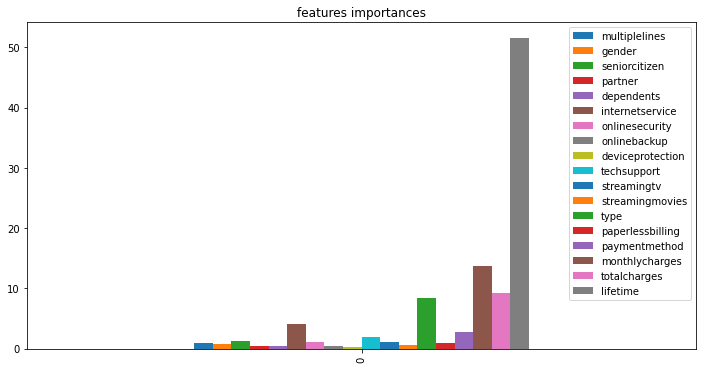

In [ ]:
#plot featuers impotances
feature_importance.plot(kind='bar', figsize=(12,6), title='features importances')

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

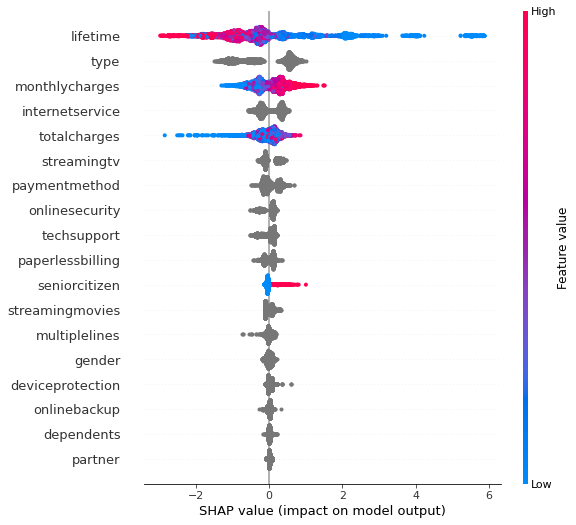

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
#find optimal hyperparameters
# cat = CatBoostClassifier(cat_features=categorical_cols, eval_metric='AUC')

# grid = {'learning_rate': [0.03, 0.1, 0.18],
#         'depth': [4, 6, 10]}

# grid_search_result = cat.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train,
#                                        stratified=True,
#                                        shuffle=True, 
#                                        plot=False)

In [ ]:
# pd.DataFrame(grid_search_result).params

In [ ]:
# retrain modelon validation dataset
model_full = CatBoostClassifier(learning_rate=0.11, #decreasing lr of retrained model should improve its performance
                           n_estimators=200, 
                           max_depth=4, 
                           class_weights=[0.265785, 0.734215], 
                           eval_metric='AUC', 
                           random_state=random_state)

In [ ]:
clf = model_full.fit(X_valid, y_valid, cat_features = categorical_cols, init_model=model)

0:	total: 2.78ms	remaining: 554ms
1:	total: 5.4ms	remaining: 535ms
2:	total: 6.7ms	remaining: 440ms
3:	total: 9.02ms	remaining: 442ms
4:	total: 11.3ms	remaining: 441ms
5:	total: 14ms	remaining: 451ms
6:	total: 15.6ms	remaining: 429ms
7:	total: 17.9ms	remaining: 428ms
8:	total: 20.3ms	remaining: 430ms
9:	total: 22.4ms	remaining: 426ms
10:	total: 25.1ms	remaining: 431ms
11:	total: 26.1ms	remaining: 409ms
12:	total: 28.6ms	remaining: 411ms
13:	total: 30.8ms	remaining: 410ms
14:	total: 33.6ms	remaining: 414ms
15:	total: 36ms	remaining: 414ms
16:	total: 38.5ms	remaining: 414ms
17:	total: 40.8ms	remaining: 413ms
18:	total: 44.8ms	remaining: 427ms
19:	total: 52.1ms	remaining: 469ms
20:	total: 57ms	remaining: 486ms
21:	total: 60.8ms	remaining: 492ms
22:	total: 63.2ms	remaining: 486ms
23:	total: 65.6ms	remaining: 481ms
24:	total: 68.9ms	remaining: 482ms
25:	total: 71.1ms	remaining: 476ms
26:	total: 73.8ms	remaining: 473ms
27:	total: 75.9ms	remaining: 466ms
28:	total: 78.5ms	remaining: 463ms
29:

In [ ]:
#on test
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.890502456372851

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


Text(0.5, 1.0, 'ROC curve')

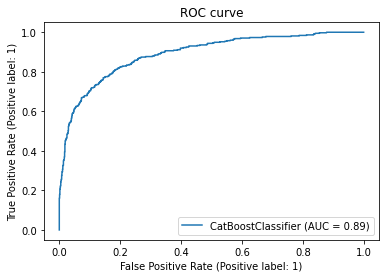

In [ ]:
# plot ROC curve
metrics.plot_roc_curve(model_full, X_test, y_test)
plt.title('ROC curve')

Model shows pretty well TPR - almost 0.9 at FPR = 0.3 

In [ ]:
accuracy_score(y_test, model.predict(X_test))

0.8102345415778252

In [ ]:
#run dummy test
dummy_clf = DummyClassifier(strategy="most_frequent")
dum = dummy_clf.fit(X, y)
# dummy_clf.score(X, y)
roc_auc_score(y, dum.predict_proba(X)[:, 1])

0.5

Dummy test's passed

##Conclusion

In this part we've learned a gradient boosting model, found optimal hyperparameters and refitted a model on validation dataset. Model shows AUC metric equals 0.89. Also it's good to see that high True Positive Ratio achieves at relatively low False Positive Ratio. As expected clients lifetime became the most important feature.


## General Conclusion

Summurizing all the above we can say that we've built the model for prediction clients churn. It means company can buy itself some time to improve the relationship with their customers and maybe avoid their loss.
